## **※ 런타임 유형을 GPU로 설정**

**개체명 인식**(**NER**, Named Entity Recognition) :

- 문맥을 파악해서 인명, 기관명, 지명 등과 같은 문장 또는 문서에서 특정한 의미를 가지고 있는 단어 또는 어구를 인식하는 과정
- 감정 뷴류/유사도 분류(마지막 히든 벡터값 사용)와 비슷하나 개체명 인식(NER)은 문장의 모든 입력값을 개체명으로 예측해야 하기 때문에 **모든 은닉 벡터값 사용**

## 환경 준비

In [ ]:
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/requirements.txt -O requirements.txt
!pip install -r requirements.txt
!pip install tensorflow==2.2.0
!pip install seqeval

--2025-04-25 02:42:43--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 610 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     610  --.-KB/s    in 0s      

2025-04-25 02:42:43 (34.6 MB/s) - ‘requirements.txt’ saved [610/610]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
!mkdir -p data_in/KOR/NER
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/NER/label.txt \
        -O data_in/KOR/NER/label.txt
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/NER/test.tsv \
        -O data_in/KOR/NER/test.tsv
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/NER/train.tsv \
        -O data_in/KOR/NER/train.txt

--2025-04-25 02:43:11--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/NER/label.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173 [text/plain]
Saving to: ‘data_in/KOR/NER/label.txt’

data_in/KOR/NER/lab 100%[===================>]     173  --.-KB/s    in 0s      

2025-04-25 02:43:11 (9.95 MB/s) - ‘data_in/KOR/NER/label.txt’ saved [173/173]

--2025-04-25 02:43:11--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/NER/test.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
H

In [ ]:
import os
import re
import numpy as np
from tqdm import tqdm
import json
import copy

import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: '__init_subclass__' (from 'transformers.agents.tools') is deprecated and will be removed from version '4.51.0'. Switch to smolagents instead, with the same functionalities and similar API (https://huggingface.co/docs/smolagents/index)
  warnings.warn(warning_message, FutureWarning)
GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.
TAPAS models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version. Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.


In [ ]:
# 시각화
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string])
    plt.show()

## 1. 데이터 불러오기

**Naver NLP Challenge 2018의 개체명 인식 데이터**

- 학습 데이터 81,000개, 테스트 데이터 9,000개로 나눴고 라벨은 총 30개로 구성되어 있다.
- 개체명 인식 데이터들은 모두 ‘./data_in/KOR/NER’ 아래에 위치해 있다.

In [ ]:
DATA_IN_PATH = '/data_in/KOR'
DATA_OUT_PATH = "/data_out/KOR"

In [ ]:
# 데이터 위치 지정
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "NER", "train.txt")
DATA_LABEL_PATH = os.path.join(DATA_IN_PATH, "NER", "label.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "NER", "test.tsv")

문장 분석을 위해 데이터의 위치를 지정한 후, 학습 데이터와 테스트 데이터를 각각 리스트 형태로 저장하고 두 데이터를 합치는 과정을 진행하자.

In [ ]:
#  문장(sentences)과 라벨(labels)을 리스트 형태로 반환
def read_file(input_path):
    """Read tsv file, and return words and label as list"""
    with open(input_path, "r", encoding="utf-8") as f:
        sentences = []
        labels = []
        for line in f:
            # strip()으로 앞뒤 공백 문자를 제거하고, split("\t")으로 탭 문자를 기준으로 나눔
            split_line = line.strip().split("\t")
            # 첫 번째 항목은 문장(split_line[0]), 두 번째 항목은 라벨(split_line[1])이라 하고 각각 리스트에 추가
            sentences.append(split_line[0])
            labels.append(split_line[1])
        return sentences, labels

In [ ]:
# 학습 데이터 DataFrame
train_sentences, train_labels = read_file('/content/data_in/KOR/NER/train.txt')
train_ner_dict = {"sentence": train_sentences, "label": train_labels}
train_ner_df = pd.DataFrame(train_ner_dict)

# 테스트 데이터 DataFrame
test_sentences, test_labels = read_file('/content/data_in/KOR/NER/test.tsv')
test_ner_dict = {"sentence": test_sentences, "label": test_labels}
test_ner_df = pd.DataFrame(test_ner_dict)

print("개체명 인식 학습 데이터 개수: {}".format(len(train_ner_df)))
print("개체명 인식 테스트 데이터 개수: {}".format(len(test_ner_df)))

개체명 인식 학습 데이터 개수: 81000
개체명 인식 테스트 데이터 개수: 9000


In [ ]:
train_ner_df.head(5)

,sentence,label
0,"금석객잔 여러분, 감사드립니다 .",ORG-B O O O
1,이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .,PER-B O O O TIM-B TIM-I CVL-B O O O O O
2,7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권...,EVT-B EVT-I PER-B PER-I O LOC-B O EVT-B CVL-B O O
3,스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서...,LOC-B NUM-B NUM-I O O O O O O O O O O O O O CV...
4,보니까 저 옆에 사조가 있어요 .,O O O O O O


In [ ]:
# Label 불러오기
def get_labels(label_path):
    return [label.strip() for label in open(os.path.join(label_path), 'r', encoding='utf-8')]

ner_labels = get_labels('/content/data_in/KOR/NER/label.txt')

print("개체명 인식 레이블 개수: {}".format(len(ner_labels)))

개체명 인식 레이블 개수: 30


## 2. 한국어 개체명 **텍스트 분석**

개체명 텍스트 분석을 위해 **문장의 길이와 어휘를 분석**하자.

기존에 라벨이 지정된 띄어쓰기 단위에 따른 길이 분석과 BERT Tokenizer를 통한 문장 토큰화 이후 길이 붆석을 통해 모델에 필요한 정보를 탐색해 보자.

또한 텍스트 어휘 분석을 통해 주로 출몰하는 단어가 무엇인지 확인해보자.

In [ ]:
# 문장별 단어 수 계산
train_word_counts = [len(sentence.split(' ')) for sentence in train_sentences]

# 통계 출력
print('문장 단어 개수 최대 값 : {}'.format(np.max(train_word_counts)))
print('문장 단어 개수 평균 값 : {:.2f}'.format(np.mean(train_word_counts)))
print('문장 단어 개수 표준편차 : {:.2f}'.format(np.std(train_word_counts)))
print('문장 단어 개수 중간값 : {:.2f}'.format(np.median(train_word_counts)))
print('문장 단어 개수 제1사분위 : {:.2f}'.format(np.percentile(train_word_counts, 25)))
print('문장 단어 개수 제3사분위 : {:.2f}'.format(np.percentile(train_word_counts, 75)))
print('문장 단어 개수 99 퍼센트 : {:.2f}'.format(np.percentile(train_word_counts, 99)))

문장 단어 개수 최대 값 : 175
문장 단어 개수 평균 값 : 11.81
문장 단어 개수 표준편차 : 7.03
문장 단어 개수 중간값 : 10.00
문장 단어 개수 제1사분위 : 7.00
문장 단어 개수 제3사분위 : 15.00
문장 단어 개수 99 퍼센트 : 35.00


- 학습 데이터에서 가장 긴 문장은 175개의 단어로 이루어져 있음
- 전체 문장의 평균적인 길이는 약 11.81개 단어
- 표준편차 7.03 -> 보통은 5~18 단어
- 가운데 위치한 문장의 단어 수가 10
- 전체 문장을 길이 순으로 정렬했을 때,
    
    앞쪽 25% 문장들은 7단어 이하이며, 뒤쪽 25% 문장들은 15단어 이상
    
- 전체 문장 중 99%는 35단어 이하 → 35단어를 초과하는 문장은 매우 드뭄

**문장 길이의 시각화**를 통해 고르게 분포되어 있는지 확인하자.

Text(0, 0.5, 'Probability')

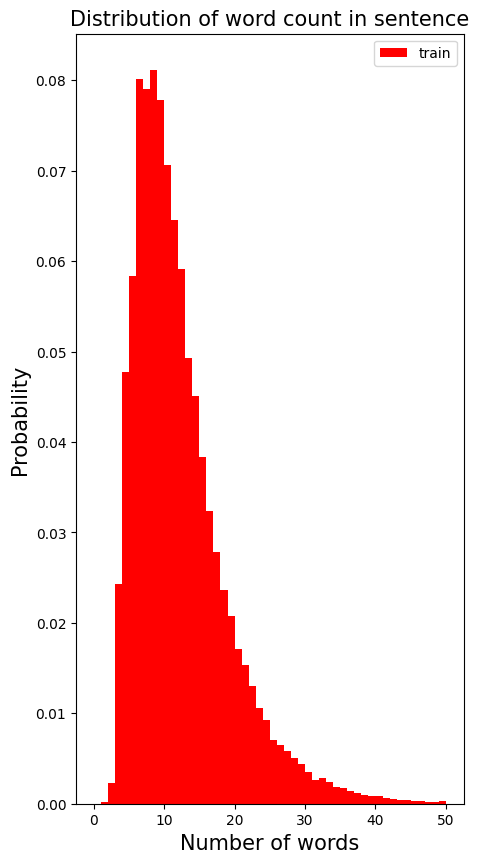

In [ ]:
plt.figure(figsize=(5, 10))
plt.hist(train_word_counts, bins=50, range=[0,50], facecolor='r', density=True, label='train')
plt.title('Distribution of word count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

박스 플롯을 통해 **이상치**가 있는 데이터들을 확인해보자.

<ipython-input-12-92dd87647387>:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(train_word_counts,


{'whiskers': [<matplotlib.lines.Line2D at 0x7d55080e8fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7d55080e8f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7d55080e87d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7d55080eb590>],
 'fliers': [<matplotlib.lines.Line2D at 0x7d55080f4750>],
 'means': [<matplotlib.lines.Line2D at 0x7d55080ebe50>]}

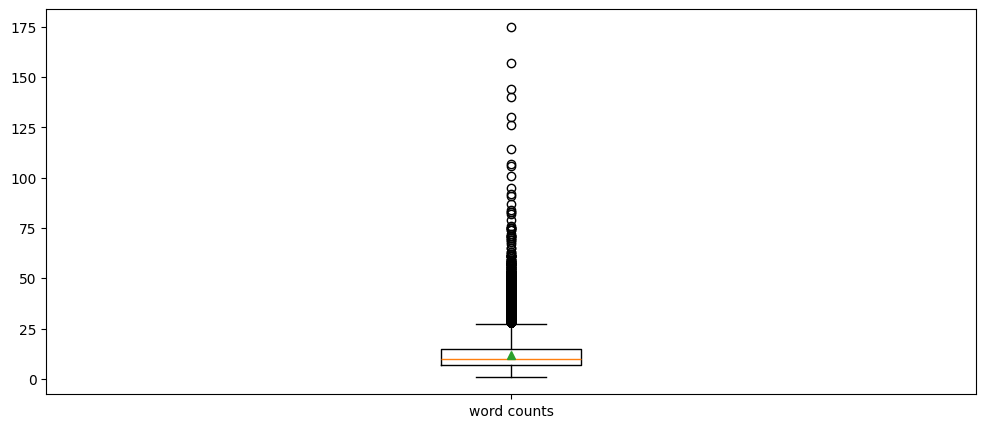

In [ ]:
plt.figure(figsize=(12, 5))
plt.boxplot(train_word_counts,
            labels=['word counts'],
            showmeans=True) # showmeans: 평균값을 마크함

**BERT Tokenzier**를 이용해 문장을 분석해서 **데이터의 특징**과 **모델에 필요한 값**을 추출해보자.

In [ ]:
# BERT Tokenzier
tokenizer = BertTokenizer.from_pretrained(
    "bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

loading file vocab.txt from cache at bert_ckpt/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at bert_ckpt/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/tokenizer_config.json
loading file tokenizer.json from cache at bert_ckpt/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/tokenizer.json
loading file chat_template.jinja from cache at None


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

loading configuration file config.json from cache at bert_ckpt/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}



In [ ]:
# 문장별 토큰 수 계산
train_bert_token_counts = [len(tokenizer.tokenize(sentence)) for sentence in train_sentences]

# 통계 출력
print('문장 토큰 개수 최대 값 : {}'.format(np.max(train_bert_token_counts)))
print('문장 토큰 개수 평균 값 : {:.2f}'.format(np.mean(train_bert_token_counts)))
print('문장 토큰 개수 표준편차 : {:.2f}'.format(np.std(train_bert_token_counts)))
print('문장 토큰 개수 중간값 : {:.2f}'.format(np.median(train_bert_token_counts)))
print('문장 토큰 개수 제1사분위 : {:.2f}'.format(np.percentile(train_bert_token_counts, 25)))
print('문장 토큰 개수 제3사분위 : {:.2f}'.format(np.percentile(train_bert_token_counts, 75)))
print('문장 토큰 개수 99 퍼센트 : {:.2f}'.format(np.percentile(train_bert_token_counts, 99)))

문장 토큰 개수 최대 값 : 850
문장 토큰 개수 평균 값 : 33.60
문장 토큰 개수 표준편차 : 22.73
문장 토큰 개수 중간값 : 28.00
문장 토큰 개수 제1사분위 : 19.00
문장 토큰 개수 제3사분위 : 41.00
문장 토큰 개수 99 퍼센트 : 111.00


<ipython-input-15-f0cc0ac5768b>:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(train_bert_token_counts,


{'whiskers': [<matplotlib.lines.Line2D at 0x7d5508113a10>,
 'caps': [<matplotlib.lines.Line2D at 0x7d550a0e0bd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7d5508119290>],
 'medians': [<matplotlib.lines.Line2D at 0x7d5504872790>],
 'fliers': [<matplotlib.lines.Line2D at 0x7d550a102490>],
 'means': [<matplotlib.lines.Line2D at 0x7d550a101c90>]}

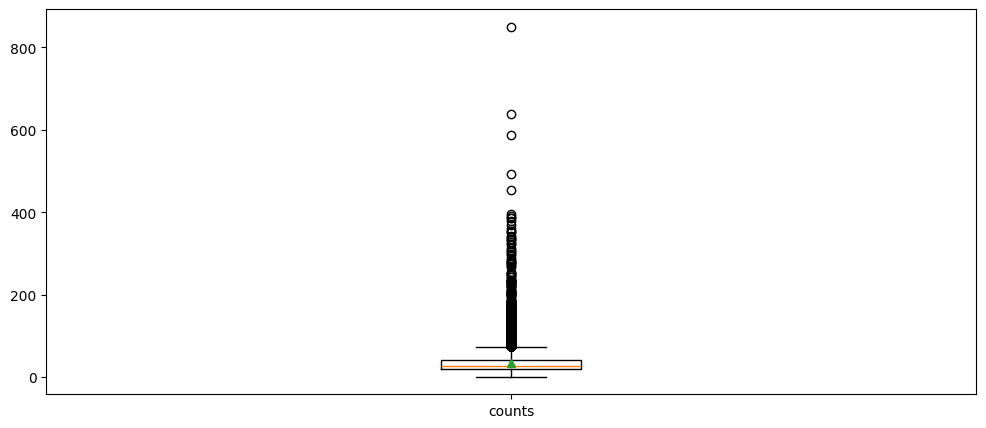

In [ ]:
plt.figure(figsize=(12, 5))
plt.boxplot(train_bert_token_counts,
            labels = ['counts'],
            showmeans=True)

모든 데이터를 활용하기 위해 최대 길이인 850을 포함하는 것은 학습 및 메모리 사이즈로 인해 현실적이지 않다.

여기서는 최종적으로 무장 토큰 길이 전체 값의 99% 백분위수인 111을 최대 길이로 선정했다.

## 3. NER 데이터 전처리

In [ ]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
MAX_LEN = 111 # EDA에서 추출된 Max Length

In [ ]:
# 데이터 전처리 준비

#  문장(sentences)과 라벨(labels)을 리스트 형태로 반환
def read_file(input_path):
    """Read tsv file, and return words and label as list"""
    with open(input_path, "r", encoding="utf-8") as f:
        sentences = []
        labels = []
        for line in f:
            # strip()으로 앞뒤 공백 문자를 제거하고, split("\t")으로 탭 문자를 기준으로 나눔
            split_line = line.strip().split("\t")
            # 첫 번째 항목은 문장(split_line[0]), 두 번째 항목은 라벨(split_line[1])이라 하고 각각 리스트에 추가
            sentences.append(split_line[0])
            labels.append(split_line[1])
        return sentences, labels

# 학습 데이터 DataFrame
train_sentences, train_labels = read_file('/content/data_in/KOR/NER/train.txt')
train_ner_dict = {"sentence": train_sentences, "label": train_labels}
train_ner_df = pd.DataFrame(train_ner_dict)

# 테스트 데이터 DataFrame
test_sentences, test_labels = read_file('/content/data_in/KOR/NER/test.tsv')
test_ner_dict = {"sentence": test_sentences, "label": test_labels}
test_ner_df = pd.DataFrame(test_ner_dict)

개체명 인식 학습 데이터 개수: 81000
개체명 인식 테스트 데이터 개수: 9000


In [ ]:
# BERT Tokenzier 설정
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt')
# cache_dir='bert_ckpt'는 모델 파일이 저장될 경로

pad_token_id = tokenizer.pad_token_id # 주어진 입력의 길이기반으로 패딩하기 위해 필요한 값
pad_token_label_id = 0 # 학습시 라벨된 값 외에 학습에 영향을 미치지 않기 위해 설정되는 값
cls_token_label_id = 0 # [CLS] 토큰에 부여할 라벨 ID (영향X)
sep_token_label_id = 0 # [SEP] 토큰에 부여할 라벨 ID (영향X)

loading file vocab.txt from cache at bert_ckpt/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at bert_ckpt/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/tokenizer_config.json
loading file tokenizer.json from cache at bert_ckpt/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/tokenizer.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at bert_ckpt/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropo

BERT Tokenizer를 통한 학습 데이터를 손쉽게 학습하 수 있도록 bert_tokenizer 함수를 생성하자.

In [ ]:
def bert_tokenizer(sent, MAX_LEN):

    encoded_dict = tokenizer.encode_plus(
        text = sent,
        truncation=True,
        add_special_tokens = True, #'[CLS]'와 '[SEP]' 추가
        max_length = MAX_LEN,           # 문장 패딩 및 자르기 진행
        pad_to_max_length = True,
        return_attention_mask = True   # 어탠션 마스크 생성
    )

    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask']
    token_type_id = encoded_dict['token_type_ids']

    return input_id, attention_mask, token_type_id

뛰어쓰기 단위에 맞게 구성되어 있는 라벨을 BERT Tokenizer에 맞는 형태로 변형해 보자.

- BERT Tokenizer로 분해된 개체명의 첫 버트 토큰 부분의 시작을 상징하는 B라벨로 지정하고,
- 나머지 부분은 내부를 상징하는 I로 지정하는 방식을 사용할 것이다.

In [ ]:
# 뛰어쓰기 단위의 라벨을 토큰 단위로 변환
def convert_label(words, labels_idx, ner_begin_label, max_seq_len):
    tokens = []
    label_ids = []

    for word, slot_label in zip(words, labels_idx):

        word_tokens = tokenizer.tokenize(word)
        if not word_tokens:
            word_tokens = [unk_token] # 개체명 인식 라벨에 포함X -> [UNK]
        tokens.extend(word_tokens)

        # 슬롯 레이블 값이 Begin이면 I로 추가
        if int(slot_label) in ner_begin_label:
            label_ids.extend([int(slot_label)] + [int(slot_label) + 1] * (len(word_tokens) - 1))
        else:
            label_ids.extend([int(slot_label)] * len(word_tokens))

    # [CLS] and [SEP] 설정
    special_tokens_count = 2
    if len(label_ids) > max_seq_len - special_tokens_count:
        label_ids = label_ids[: (max_seq_len - special_tokens_count)]

    # [SEP] 토큰 추가
    label_ids += [sep_token_label_id]

    # [CLS] 토큰 추가
    label_ids = [cls_token_label_id] + label_ids

    padding_length = max_seq_len - len(label_ids)
    label_ids = label_ids + ([pad_token_label_id] * padding_length)

    return label_ids

이제 각 구성요소를 활용해 **학습 데이터**를 **제작**하는 함수를 구성해 보자.

In [ ]:
# 테스트용
ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if "B" in begin_label]
ner_begin_label_string = [ner_labels[label_index] for label_index in ner_begin_label]

print(ner_begin_label)
print(ner_begin_label_string)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
['PER-B', 'FLD-B', 'AFW-B', 'ORG-B', 'LOC-B', 'CVL-B', 'DAT-B', 'TIM-B', 'NUM-B', 'EVT-B', 'ANM-B', 'PLT-B', 'MAT-B', 'TRM-B']


In [ ]:
# B로 시작하는 라벨에 대해서 저장
ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if "B" in begin_label]

def create_inputs_targets(df):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    label_list = []

		# 1. 각 데이터프레임의 문장과 라벨을 띄어쓰기 단위로 만들어
		# 각각 words와 labels 변수에 저장
    for i, data in enumerate(df[['sentence', 'label']].values):
        sentence, labels = data
        words = sentence.split()
        labels = labels.split()
        labels_idx = []

        # 2. label_idx에 labels의 값들을 인덱스로 변환
        for label in labels:
            labels_idx.append(ner_labels.index(label) if label in ner_labels else ner_labels.index("UNK"))
						# 라벨이 정의 안 돼 있으면 "UNK" 인덱스로 대체
        assert len(words) == len(labels_idx)

        # 3. bert_tokenizer에서 BERT에 필요한
        # input_id, attention_mask, token_type_id 생성
        input_id, attention_mask, token_type_id = bert_tokenizer(sentence, MAX_LEN)

        # 4. 라벨 토큰 단위로 변환
        convert_label_id = convert_label(words, labels_idx, ner_begin_label, MAX_LEN)

				# 5. 리스트에 저장
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        label_list.append(convert_label_id)

		# 6. 넘파이 배열로 변환 후 반환
    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    label_list = np.asarray(label_list, dtype=int) #레이블 토크나이징 리스트
    inputs = (input_ids, attention_masks, token_type_ids)

    return inputs, label_list

train_inputs, train_labels = create_inputs_targets(train_ner_df) # 학습 데이터
test_inputs, test_labels = create_inputs_targets(test_ner_df) # 테스트 데이터

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

## 4. NER 모델 학습 및 테스트

개체명 인식 학습을 위한 **모델**을 구성해보자.

In [ ]:
class TFBertNERClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertNERClassifier, self).__init__()

        # 사전 학습된 BERT 모델
        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        # BERT에서 사용하는 드롭아웃 확률 그대로 설정
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        # 각 토큰을 num_class 개의 개체명 카테고리 중 하나로 분류하는 Dense layer
        self.classifier = tf.keras.layers.Dense(num_class,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                                name="ner_classifier")

    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        # BERT 통과
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[0]
        # 차원 = 임베딩 크기 * 최대 문장의 길 (768차원 * 111개)

        # Dropout 적용 & Dense 분류기 통과 -> 각 토큰을 NER 레이블로 분류
        sequence_output = self.dropout(sequence_output, training=training)
        logits = self.classifier(sequence_output)
        # 각 시퀀스 입력 111개를 해당 개체명 라벨의 개수(near_labels, 30개)로 분류
        # ex. (32, 111, 30) → 30개의 클래스


        return logits # Softmax를 적용하기 전

In [ ]:
ner_model = TFBertNERClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=len(ner_labels))

loading configuration file config.json from cache at bert_ckpt/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}

Xet Storage is enabled for this repo, but the 'hf_xet' pack

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at bert_ckpt/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/model.safetensors
Loaded 177,853,440 parameters in the TF 2.0 model.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClas

이번에는 **손실(Loss) 값**을 확인해 보자.

In [ ]:
def compute_loss(labels, logits):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE
    ) # 소프트맥스 + 정수 라벨 손실 계산

    # 라벨이 0인 경우([PAD], [CLS], [SEP]) → 손실 계산에서 제외
    active_loss = tf.reshape(labels, (-1,)) != 0

    # active_loss=True인 부분(유효한 부분)만 추출
    reduced_logits = tf.boolean_mask(tf.reshape(logits, (-1, shape_list(logits)[2])), active_loss)
    labels = tf.boolean_mask(tf.reshape(labels, (-1,)), active_loss)

    return loss_fn(labels, reduced_logits)

NER 모델 학습에서는 데이터 라벨의 분포가 분균형(라벨 O의 비중이 크고 나머지 라벨의 비중 적음)

→ 정확도(Accuracy)로 평가한다면 예측이 잘 되지 않아도 정확도가 높게 보일 수 있음

→ **F1 Score**로 계산

In [ ]:
class F1Metrics(tf.keras.callbacks.Callback):
    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval # 예측용 입력
        self.y_eval = y_eval # 정답 라벨

    def compute_f1_pre_rec(self, labels, preds): # 평가 결과를 딕셔너리로 리턴
        return {
            "precision": precision_score(labels, preds, suffix=True),
            "recall": recall_score(labels, preds, suffix=True),
            "f1": f1_score(labels, preds, suffix=True)
        }


    def show_report(self, labels, preds): # 상세 리포트
        return classification_report(labels, preds, suffix=True)

    def on_epoch_end(self, epoch, logs=None): # 에포크가 끝날 때마다 실행

        results = {}

        pred = self.model.predict(self.x_eval) # 예측값
        label = self.y_eval # 실제값
        pred_argmax = np.argmax(pred, axis = 2)
        # 시퀀스 각각의 가장 높은 라벨 예측값 출력

        # 숫자 → 태그 변환
        slot_label_map = {i: label for i, label in enumerate(ner_labels)}

        out_label_list = [[] for _ in range(label.shape[0])]
        preds_list = [[] for _ in range(label.shape[0])]

        for i in range(label.shape[0]): # 평가 데이터 정답 인스턴스 수(9000)
            for j in range(label.shape[1]): # 각 라벨의 길이(111)
                if label[i, j] != 0: # 라벨 0 제외(유효한 토큰만 정제)
                    out_label_list[i].append(slot_label_map[label[i][j]])
                    preds_list[i].append(slot_label_map[pred_argmax[i][j]])

        result = self.compute_f1_pre_rec(out_label_list, preds_list)
        results.update(result)

        print("********")
        print("F1 Score")
        for key in sorted(results.keys()):
            print("{}, {:.4f}".format(key, results[key]))
        print("\n" + self.show_report(out_label_list, preds_list))
        print("********")

f1_score_callback = F1Metrics(test_inputs, test_labels)

compute_f1_pre_rec 함수를 통해 텍스트 레이블로 치환된 예측값과 정답 레이블 값을 계산하고,

딕셔너리 값인 results에 점수를 업데이트해서

F1 score, 정밀도, 재현율을 계산한다.

이제 손실값 함수와 optimizer 및 학습 metric을 설정한 후 컴파일을 진행한다.

In [ ]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(3e-5)
# ner_model.compile(optimizer=optimizer, loss=compute_loss, run_eagerly=True)
ner_model.compile(optimizer=optimizer, loss=compute_loss)

In [ ]:
model_name = "tf2_bert_ner"

# 파일 경로에 .weights.h5 확장자 추가
checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'bert_model.weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# 폴더 생성
if os.path.exists(checkpoint_dir):
    print(f"{checkpoint_dir} -- Folder already exists \n")
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print(f"{checkpoint_dir} -- Folder create complete \n")

# 체크포인트 콜백 설정
cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True
)

# 모델 학습
history = ner_model.fit(
    train_inputs, train_labels,
    batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
    callbacks=[cp_callback, f1_score_callback]
)

print(history.history)

/data_out/KOR/tf2_bert_ner -- Folder already exists 

Epoch 1/3
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 2.1566

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


282/282 ━━━━━━━━━━━━━━━━━━━━ 62s 207ms/step
********
F1 Score
f1, 0.0798
precision, 0.0881
recall, 0.0729


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



              precision    recall  f1-score   support

         AFW       0.00      0.00      0.00       393
         ANM       0.00      0.00      0.00       699
         CVL       0.01      0.00      0.00      5735
         DAT       0.23      0.11      0.15      2510
         EVT       0.03      0.03      0.03      1093
         FLD       0.00      0.00      0.00       228
         LOC       0.00      0.00      0.00      2124
         MAT       0.00      0.00      0.00        12
         NUM       0.18      0.19      0.19      5544
         ORG       0.01      0.02      0.02      4055
         PER       0.11      0.13      0.12      4412
         PLT       0.00      0.00      0.00        34
         TIM       0.00      0.00      0.00       314
         TRM       0.03      0.02      0.02      1950

   micro avg       0.09      0.07      0.08     29103
   macro avg       0.04      0.04      0.04     29103
weighted avg       0.08      0.07      0.07     29103

********
2532/2532 ━━━━━

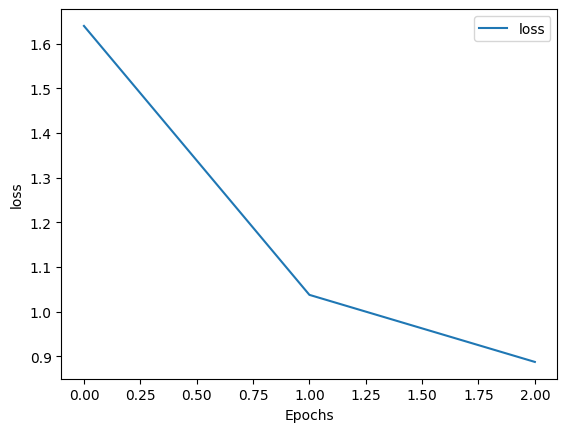

In [ ]:
plot_graphs(history, 'loss')